In [1]:
from transformers import BertForSequenceClassification
import torch
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import importlib

from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rd81\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
n_labels = 2

epochs = 12
lr = 0.00001
manual_loss= False
batch_sizes = 16
max_len = 100

loss = 'cross_ent'

run_data = {}

In [3]:
# to test

# pick a set of params and then run all the models and pick the best performing one on val and the test and val

In [4]:
include_dev=False
batch_size_train = 16
batch_size_test = 16
batch_size_dev = 16

if include_dev:
    train_df, val_df, test_df = get_processed_data(dev=True)
    
    train_df= get_cols_for_bert(train_df, 'prop')
    val_df= get_cols_for_bert(val_df, 'prop')
    test_df= get_cols_for_bert(test_df, 'prop')
    
    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df, max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df, max_len=64)
    test_input_embeddings_labelled = format_and_tokenise_from_df(test_df, max_len=64)
    
    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    test_dataset = CustomPropagandaDataset(test_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)
    


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev, shuffle=True)
    
    
else:
    train_df, val_df = get_processed_data(dev=False)
    
    train_df= get_cols_for_bert(train_df, 'prop')
    val_df= get_cols_for_bert(val_df, 'prop')
    
    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df, max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df, max_len=64)
    
    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev, shuffle=True)
    
def plot_training(train_losses, train_accuracy, val_losses, val_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set x-axis ticks to only be at each epoch

    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Set x-axis ticks to only be at each epoch

    plt.ylim(0, 1)  # This sets the y-axis to be between 0 and 1

    plt.legend()

    plt.tight_layout()
    plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAIN: Epoch [1/12] Loss: 0.6788904897868633 Acc: 0.58125


VAL: Epoch [1/12] Loss: 0.6586317211389542 Acc: 0.6203125


TRAIN: Epoch [2/12] Loss: 0.6439442753791809 Acc: 0.632421875


VAL: Epoch [2/12] Loss: 0.6431834474205971 Acc: 0.6328125


TRAIN: Epoch [3/12] Loss: 0.5946080718189478 Acc: 0.683984375


VAL: Epoch [3/12] Loss: 0.6933319114148617 Acc: 0.603125


TRAIN: Epoch [4/12] Loss: 0.5040782360360027 Acc: 0.757421875


VAL: Epoch [4/12] Loss: 0.7043907821178437 Acc: 0.640625


TRAIN: Epoch [5/12] Loss: 0.35003895410336555 Acc: 0.8484375


VAL: Epoch [5/12] Loss: 0.7470230050384998 Acc: 0.6578125


TRAIN: Epoch [6/12] Loss: 0.25261010725516825 Acc: 0.905859375


VAL: Epoch [6/12] Loss: 0.8080524064600467 Acc: 0.65625


TRAIN: Epoch [7/12] Loss: 0.17435716798063366 Acc: 0.93515625


VAL: Epoch [7/12] Loss: 1.169163841754198 Acc: 0.6390625


TRAIN: Epoch [8/12] Loss: 0.11826658089412376 Acc: 0.9625


VAL: Epoch [8/12] Loss: 1.166452345997095 Acc: 0.6609375


TRAIN: Epoch [9/12] Loss: 0.08264216333627701 Acc: 0.974609375


VAL: Epoch [9/12] Loss: 1.2137273967266082 Acc: 0.66875


TRAIN: Epoch [10/12] Loss: 0.09673492427100427 Acc: 0.969140625


VAL: Epoch [10/12] Loss: 1.2413247719407081 Acc: 0.6484375


TRAIN: Epoch [11/12] Loss: 0.06047598171280697 Acc: 0.98046875


VAL: Epoch [11/12] Loss: 1.4501310214400291 Acc: 0.6515625


TRAIN: Epoch [12/12] Loss: 0.040180680579214825 Acc: 0.98828125


VAL: Epoch [12/12] Loss: 1.3621693588793278 Acc: 0.6546875


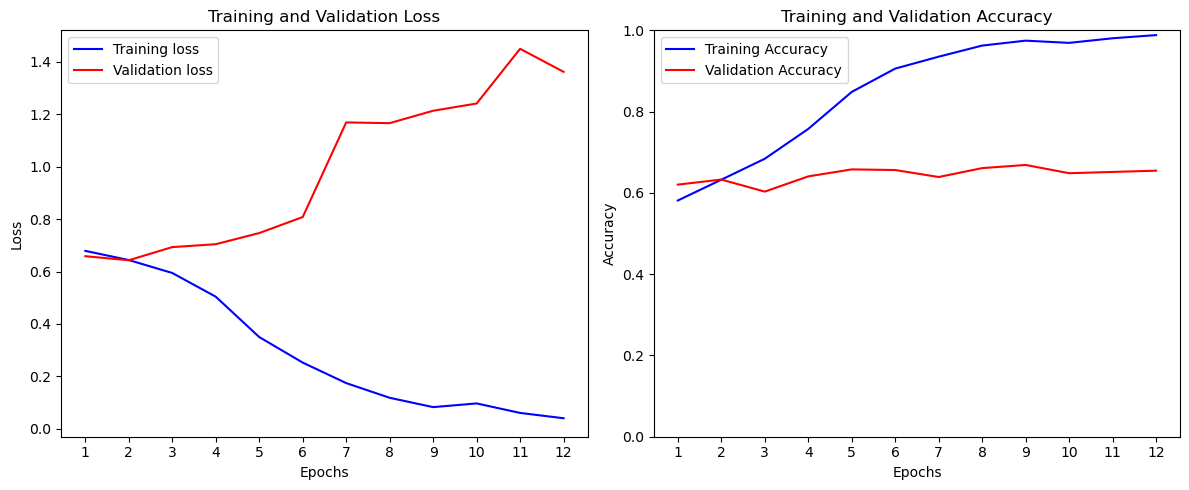

In [5]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        if manual_loss:
            loss = criterion(outputs.logits, batch['labels'])
        else:
            loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        _, indices = torch.max(outputs['logits'], dim=1)
        predicted_labels = indices
        train_total += batch['labels'].size(0)
        train_correct += (predicted_labels == batch['labels']).sum().item()
        train_running_losses.append(loss.item())
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch+1}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            _, indices = torch.max(outputs['logits'], dim=1)
            predicted_labels = indices
            
            val_total += batch['labels'].size(0)
            val_correct += (predicted_labels == batch['labels']).sum().item()
            val_running_losses.append(loss.item())
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch+1}/{epochs}] Loss: {sum(val_running_losses)/len(val_running_losses)} Acc: {val_correct/val_total}')
    
    if include_dev:
        print('TESTING...')
        test_losses = []
        test_accuracy = []
        
        model.eval()
        with torch.no_grad():
            test_running_losses = []
            test_total = 0
            test_correct = 0
            
            for batch in test_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                
                _, indices = torch.max(outputs['logits'], dim=1)
                predicted_labels = indices
                
                test_total += batch['labels'].size(0)
                test_correct += (predicted_labels == batch['labels']).sum().item()
                test_running_losses.append(loss.item())
            
            test_losses.append(sum(test_running_losses) / len(test_running_losses))
            test_accuracy.append(test_correct / test_total)
            print(f'TEST: Epoch [{epoch+1}/{epochs}] Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')
 
plot_training(train_losses, train_accuracy, val_losses, val_accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAIN: Epoch [1/12] Loss: 0.668034341931343 Acc: 0.607421875


VAL: Epoch [1/12] Loss: 0.6714630804955959 Acc: 0.6


TRAIN: Epoch [2/12] Loss: 0.6446111727505922 Acc: 0.632421875


VAL: Epoch [2/12] Loss: 0.6401666909456253 Acc: 0.65


TRAIN: Epoch [3/12] Loss: 0.5956137884408236 Acc: 0.696875


VAL: Epoch [3/12] Loss: 0.6203937292098999 Acc: 0.64375


TRAIN: Epoch [4/12] Loss: 0.49813607782125474 Acc: 0.774609375


VAL: Epoch [4/12] Loss: 0.6206680200994015 Acc: 0.659375


TRAIN: Epoch [5/12] Loss: 0.37381204441189764 Acc: 0.8390625


VAL: Epoch [5/12] Loss: 0.7081414796411991 Acc: 0.6546875


TRAIN: Epoch [6/12] Loss: 0.24693117521237581 Acc: 0.904296875


VAL: Epoch [6/12] Loss: 0.7860933564603328 Acc: 0.6765625


TRAIN: Epoch [7/12] Loss: 0.16622183753643185 Acc: 0.9375


VAL: Epoch [7/12] Loss: 1.154088656976819 Acc: 0.6484375


TRAIN: Epoch [8/12] Loss: 0.09996161732706241 Acc: 0.96015625


VAL: Epoch [8/12] Loss: 1.0661523953080176 Acc: 0.678125


TRAIN: Epoch [9/12] Loss: 0.09957138043828309 Acc: 0.96484375


VAL: Epoch [9/12] Loss: 1.2968250773847103 Acc: 0.6765625


TRAIN: Epoch [10/12] Loss: 0.04558290154018323 Acc: 0.984375


VAL: Epoch [10/12] Loss: 1.2599281340837478 Acc: 0.65


TRAIN: Epoch [11/12] Loss: 0.05053264899615897 Acc: 0.98359375


VAL: Epoch [11/12] Loss: 1.2139640919864179 Acc: 0.6515625


TRAIN: Epoch [12/12] Loss: 0.03618409291593707 Acc: 0.989453125


VAL: Epoch [12/12] Loss: 1.5163823798298837 Acc: 0.6734375


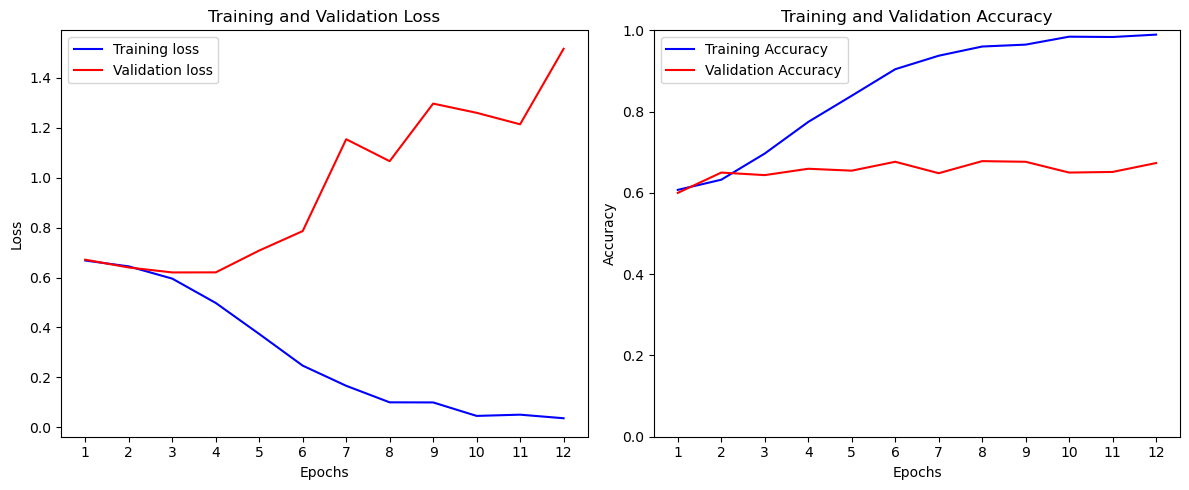

In [6]:
# using binary class specific settings:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        if manual_loss:
            loss = criterion(outputs.logits.view(-1), batch['labels'].float())
        else:
            loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted_labels = outputs.logits.argmax(dim=1)
        train_total += batch['labels'].size(0)
        train_correct += (predicted_labels == batch['labels']).sum().item()
        train_running_losses.append(loss.item())
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch+1}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            predicted_labels = outputs.logits.argmax(dim=1)
            
            val_total += batch['labels'].size(0)
            val_correct += (predicted_labels == batch['labels']).sum().item()
            val_running_losses.append(loss.item())
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch+1}/{epochs}] Loss: {sum(val_running_losses)/len(val_running_losses)} Acc: {val_correct/val_total}')
    
    if include_dev:
        print('TESTING...')
        test_losses = []
        test_accuracy = []
        
        model.eval()
        with torch.no_grad():
            test_running_losses = []
            test_total = 0
            test_correct = 0
            
            for batch in test_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                
                predicted_labels = outputs.logits.argmax(dim=1)
                
                test_total += batch['labels'].size(0)
                test_correct += (predicted_labels == batch['labels']).sum().item()
                test_running_losses.append(loss.item())
            
            test_losses.append(sum(test_running_losses) / len(test_running_losses))
            test_accuracy.append(test_correct / test_total)
            print(f'TEST: Epoch [{epoch+1}/{epochs}] Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')
            
plot_training(train_losses, train_accuracy, val_losses, val_accuracy)

TRAIN: Epoch [1/12] Loss: 0.6840397004038096 Acc: 0.548046875


VAL: Epoch [1/12] Loss: 0.6656122401356697 Acc: 0.571875


TRAIN: Epoch [2/12] Loss: 0.66269860137254 Acc: 0.600390625


VAL: Epoch [2/12] Loss: 0.6540285274386406 Acc: 0.6265625


TRAIN: Epoch [3/12] Loss: 0.6620131636038422 Acc: 0.61171875


VAL: Epoch [3/12] Loss: 0.6431932426989079 Acc: 0.6328125


TRAIN: Epoch [4/12] Loss: 0.6421731205657124 Acc: 0.636328125


VAL: Epoch [4/12] Loss: 0.6350597187876701 Acc: 0.64375


TRAIN: Epoch [5/12] Loss: 0.5912784239277243 Acc: 0.696484375


VAL: Epoch [5/12] Loss: 0.6127740614116192 Acc: 0.6671875


TRAIN: Epoch [6/12] Loss: 0.49269067458808424 Acc: 0.7671875


VAL: Epoch [6/12] Loss: 0.6166141651570797 Acc: 0.68125


TRAIN: Epoch [7/12] Loss: 0.34874654598534105 Acc: 0.8609375


VAL: Epoch [7/12] Loss: 0.6932690270245075 Acc: 0.671875


TRAIN: Epoch [8/12] Loss: 0.2388269007205963 Acc: 0.911328125


VAL: Epoch [8/12] Loss: 0.8658045962452888 Acc: 0.665625


TRAIN: Epoch [9/12] Loss: 0.15504370096605272 Acc: 0.948046875


VAL: Epoch [9/12] Loss: 1.2236308328807355 Acc: 0.625


TRAIN: Epoch [10/12] Loss: 0.1287789208930917 Acc: 0.9515625


VAL: Epoch [10/12] Loss: 1.003816683590412 Acc: 0.6625


TRAIN: Epoch [11/12] Loss: 0.08907036123564467 Acc: 0.97421875


VAL: Epoch [11/12] Loss: 1.0944314870983363 Acc: 0.6546875


TRAIN: Epoch [12/12] Loss: 0.07408369309268892 Acc: 0.976171875


VAL: Epoch [12/12] Loss: 1.1286551743745803 Acc: 0.6484375


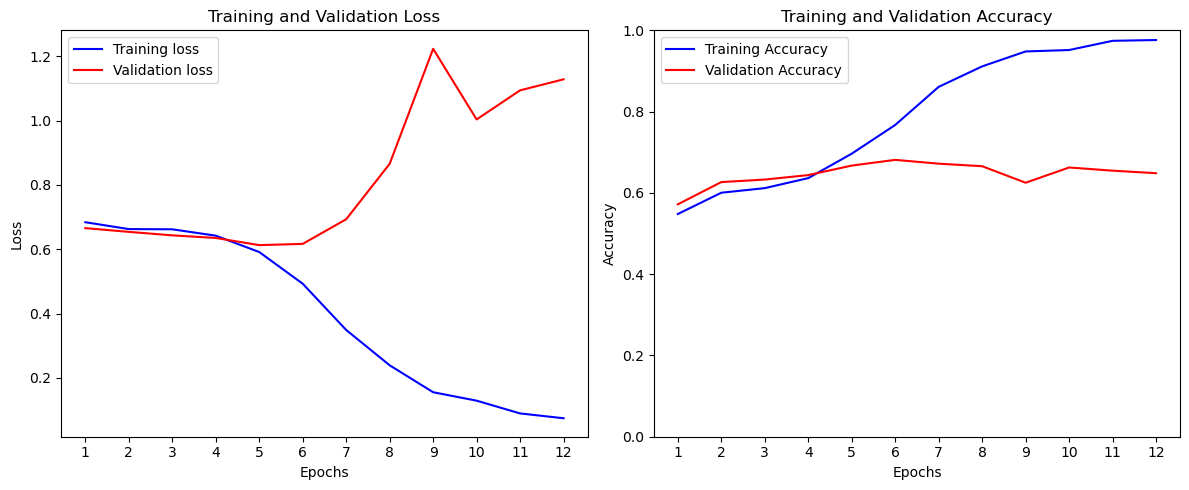

In [7]:
model = BertClassifier(num_classes=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], batch['attention_mask'])
        batch_loss = criterion(outputs, batch['labels'].long())
        train_running_losses.append(batch_loss.item())
        
        acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
        train_correct += acc
        train_total += len(batch['input_ids'])
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch + 1}/{epochs}] Loss: {sum(train_running_losses) / len(train_running_losses)} Acc: {train_correct / train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            batch_loss = criterion(outputs, batch['labels'].long())
            val_running_losses.append(batch_loss.item())
            
            acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
            val_correct += acc
            val_total += len(batch['input_ids'])
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch + 1}/{epochs}] Loss: {sum(val_running_losses) / len(val_running_losses)} Acc: {val_correct / val_total}')

if include_dev:
    print('TESTING')
    model.eval()
    with torch.no_grad():
        test_running_losses = []
        test_total = 0
        test_correct = 0
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            batch_loss=criterion(outputs,batch['labels'].long())
            
            
            test_total+=len(batch['input_ids'])
            
            
            acc=(outputs.argmax(dim=1)==batch['labels']).sum().item()
            test_correct+=acc



            test_running_losses.append(batch_loss.item())

        test_losses.append(sum(test_running_losses)/len(test_running_losses))
        test_accuracy.append(test_correct/test_total)

    print(f'TEST: Epoch [{epoch + 1}/{epochs}] Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')
plot_training(train_losses, train_accuracy, val_losses, val_accuracy)

TRAIN: Epoch [1/12] Loss: 0.6928375825285912 Acc: 0.50703125


VAL: Epoch [1/12] Loss: 0.6872401252388954 Acc: 0.6140625


TRAIN: Epoch [2/12] Loss: 0.6774702917784452 Acc: 0.61015625


VAL: Epoch [2/12] Loss: 0.6716835871338844 Acc: 0.628125


TRAIN: Epoch [3/12] Loss: 0.662690793350339 Acc: 0.63359375


VAL: Epoch [3/12] Loss: 0.6589634835720062 Acc: 0.621875


TRAIN: Epoch [4/12] Loss: 0.642702867090702 Acc: 0.6609375


VAL: Epoch [4/12] Loss: 0.6621029630303383 Acc: 0.60625


TRAIN: Epoch [5/12] Loss: 0.6210170639678836 Acc: 0.690625


VAL: Epoch [5/12] Loss: 0.7048458978533745 Acc: 0.5671875


TRAIN: Epoch [6/12] Loss: 0.5937637988477945 Acc: 0.726171875


VAL: Epoch [6/12] Loss: 0.6531563505530358 Acc: 0.634375


TRAIN: Epoch [7/12] Loss: 0.5531927201896906 Acc: 0.769140625


VAL: Epoch [7/12] Loss: 0.6327591471374034 Acc: 0.665625


TRAIN: Epoch [8/12] Loss: 0.5268130552023649 Acc: 0.795703125


VAL: Epoch [8/12] Loss: 0.6157613337039948 Acc: 0.6875


TRAIN: Epoch [9/12] Loss: 0.4915252786129713 Acc: 0.83046875


VAL: Epoch [9/12] Loss: 0.6146183922886849 Acc: 0.6890625


TRAIN: Epoch [10/12] Loss: 0.4646534912288189 Acc: 0.860546875


VAL: Epoch [10/12] Loss: 0.648902852088213 Acc: 0.6546875


TRAIN: Epoch [11/12] Loss: 0.4573596762493253 Acc: 0.863671875


VAL: Epoch [11/12] Loss: 0.6556538298726082 Acc: 0.65


TRAIN: Epoch [12/12] Loss: 0.4614076489582658 Acc: 0.85703125


VAL: Epoch [12/12] Loss: 0.6919141829013824 Acc: 0.615625


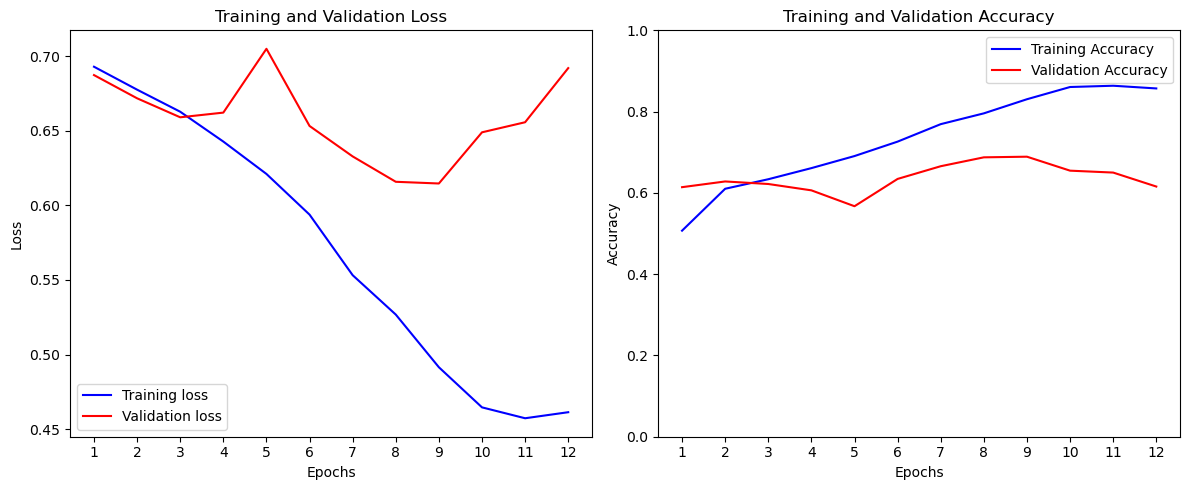

In [8]:
class BertClassifier_2(nn.Module):
    def __init__(self, dropout=0.5, num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 128)
        self.relu=nn.ReLU()
        self.linear_2 = nn.Linear(128, num_classes)

        if num_classes == 2:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_layer, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        relu_applied = self.relu(linear_output_1)
        dropout_l = self.dropout(relu_applied)
        linear_output_2 = self.linear_2(dropout_l)
        final_layer = self.activation(linear_output_2)
        return final_layer
    
    
model=BertClassifier_2(num_classes=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], batch['attention_mask'])
        batch_loss = criterion(outputs, batch['labels'].long())
        train_running_losses.append(batch_loss.item())
        
        acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
        train_correct += acc
        train_total += len(batch['input_ids'])
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch + 1}/{epochs}] Loss: {sum(train_running_losses) / len(train_running_losses)} Acc: {train_correct / train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            batch_loss = criterion(outputs, batch['labels'].long())
            val_running_losses.append(batch_loss.item())
            
            acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
            val_correct += acc
            val_total += len(batch['input_ids'])
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch + 1}/{epochs}] Loss: {sum(val_running_losses) / len(val_running_losses)} Acc: {val_correct / val_total}')

plot_training(train_losses, train_accuracy, val_losses, val_accuracy)